In [1]:
%matplotlib nbagg
import os
import numpy as np
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
path = os.getcwd()

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer) 

In [3]:
def usingSVD(dataMatrix, desiredVariancePercentage=1.0):
    # This function should implement the PCA using the Singular Value
    # Decomposition (SVD) of the given dataMatrix
    
    # De-Meaning the feature space
    meanDataMatrix = dataMatrix.mean(1)
    demeanedDataMatrix = (dataMatrix.T - meanDataMatrix)
    
    # SVD Decomposition
    # You need to transpose the data matrix
    U, s, V = np.linalg.svd(demeanedDataMatrix / np.sqrt(dataMatrix.shape[1]-1)) # Divide by sqrt(N-1) to get consistent results
    V = V.T     # Numpy gives V transposed
    
    # Enforce a sign convention on the coefficients -- the largest element (absolute) in each
    # column will have a positive sign.
    for i in range(V.shape[0]):
        if V[:,i][np.argmax(np.fabs(V[:,i]))] < 0:
            V[:,i] = -V[:,i]
            
    # Compute the accumelative Eigenvalues to finde the desired
    # Variance
    s = s**2
    acc_eigenvals = np.sum(s)
    
    # Keep the eigenvectors and eigenvalues of the desired
    # variance, i.e. keep the first two eigenvectors and
    # eigenvalues if they have 90% of variance.
    for i in range(s.shape[0]):
        if np.sum(s[:i+1])/acc_eigenvals >= desiredVariancePercentage:
            eigenvals = s[:i+1]
            eigenvecs = V[:,:i+1]
            break
    
    # Project the data
    projectedData = np.dot(demeanedDataMatrix, eigenvecs)
    
    # Return Data
    return eigenvecs, eigenvals, meanDataMatrix, demeanedDataMatrix.T, projectedData.T

In [4]:
def usingCOV(dataMatrix, desiredVariancePercentage=1.0):
    # This function should implement the PCA using the
    # EigenValue Decomposition of a given Covariance Matrix 
    
    # De-Meaning the feature space 
    meanDataMatrix = dataMatrix.mean(1)
    demeanedDataMatrix = (dataMatrix.T - meanDataMatrix)
            
    # Computing the Covariance 
    covMatrix = np.dot(demeanedDataMatrix.T, demeanedDataMatrix)
            
    # Eigen Value Decomposition
    # In COV, you need to order the eigevectors according to largest eigenvalues
    eigenValues, eigenVectors = np.linalg.eig(covMatrix / (dataMatrix.shape[1] - 1))
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    # Enforce a sign convention on the coefficients -- the largest element (absolute) in each
    # column will have a positive sign.
    for i in range(eigenVectors.shape[0]):
        if eigenVectors[:,i][np.argmax(np.fabs(eigenVectors[:,i]))] < 0:
            eigenVectors[:,i] = -eigenVectors[:,i]


    # Compute the accumelative Eigenvalues to finde the desired
    # Variance 
    acc_eigenvals = np.sum(eigenValues)
            
    # Keep the eigenvectors and eigenvalues of the desired
    # variance, i.e. keep the first two eigenvectors and
    # eigenvalues if they have 90% of variance. 
    for i in range(eigenValues.shape[0]):
        if np.sum(eigenValues[:i+1])/acc_eigenvals >= desiredVariancePercentage:
            eigenvals = eigenValues[:i+1]
            eigenvecs = eigenVectors[:,:i+1]
            break
            
    # Project the data 
    projectedData = np.dot(demeanedDataMatrix, eigenvecs)
    
    # Return data
    return eigenvecs, eigenvals, meanDataMatrix, demeanedDataMatrix.T, projectedData.T

In [5]:
data = sio.loadmat(os.path.join(path,'data','toydata.mat'))['D']

In [6]:
eigenvecs,eigenvals,meanDataMatrix,demeanedDataMatrix,projectedData = usingSVD(data)

<IPython.core.display.Javascript object>


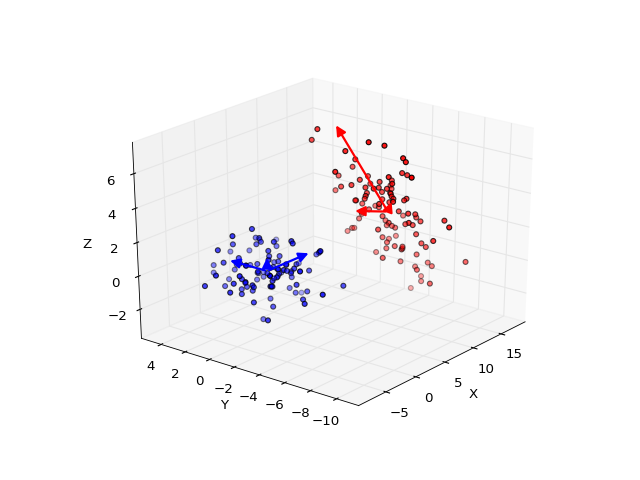

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0], data[1], data[2], c='r', marker='o')
ax.scatter(projectedData[0], projectedData[1], projectedData[2], c='b', marker='o')
for i in range(eigenvecs.shape[1]):
    v = eigenvecs.T[i]
    e = eigenvals[i]
    a = Arrow3D([meanDataMatrix[0], (e*v[0])+meanDataMatrix[0]],
                [meanDataMatrix[1], (e*v[1])+meanDataMatrix[1]], 
                [meanDataMatrix[2], (e*v[2])+meanDataMatrix[2]], 
                mutation_scale=20, 
                lw=2, arrowstyle="-|>", color="r")
    ax.add_artist(a)
b = Arrow3D([0, eigenvals[0]], [0,0], [0,0], mutation_scale=20, lw=2, arrowstyle="-|>", color="b")
c = Arrow3D([0, 0], [0,eigenvals[1]], [0,0], mutation_scale=20, lw=2, arrowstyle="-|>", color="b")
d = Arrow3D([0, 0], [0,0], [0,eigenvals[2]], mutation_scale=20, lw=2, arrowstyle="-|>", color="b")
ax.add_artist(b)
ax.add_artist(c)
ax.add_artist(d)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.draw()
plt.show()